# Creating High and Low Variance/Expression Figures

First we import necessary tools and data, along with functions used in other examples to make our correlations.

In [1]:
import cptac
import cptac.utils as ut
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statistics as st
import load_high_low_data # This allows us to load data from paper with pubmed ID 30777892

In [2]:
def correlation_list(tissue, gene_list, valid_sample_number = 30, tissue_type = "both", print_first = False):
    #Returns a list of lists containing the name of the gene and the correlation
    corr_list = []
    pval_list = []
    prot = tissue.get_proteomics(tissue_type)
    if isinstance(prot.columns, pd.MultiIndex):
        prot = ut.reduce_multiindex(df = prot, levels_to_drop="Database_ID")
    
    trans = tissue.get_transcriptomics(tissue_type)
    if isinstance(trans.columns, pd.MultiIndex):
        trans = ut.reduce_multiindex(df = trans, levels_to_drop="Database_ID")
        
    prot_index_values = list(prot.index.values)
    trans_index_values = list(trans.index.values)
    

    for found_index in prot_index_values:
        if found_index not in trans_index_values:
            prot = prot.drop(index=found_index)
    for found_index in trans_index_values:
        if found_index not in prot_index_values:
            trans = trans.drop(index=found_index)
    printed = False  
    for gene in gene_list:
        if gene not in prot or gene not in trans:
            continue
        if print_first and not printed:
            print(gene)
            printed = True
        prot_measurements = prot[gene]
        prot_count = len(prot_measurements.dropna())
        
        trans_measurements = trans[gene]
        trans_count = len(trans_measurements.dropna())
        
        if prot_count < valid_sample_number or trans_count < valid_sample_number:
            continue
            
        nan_indices = set()
        prot_indices = list(prot_measurements.index.values)
        trans_indices = list(trans_measurements.index.values)
        
        #Here we are only currently taking the first column of multi_indices
        if isinstance(prot_measurements, pd.core.frame.DataFrame): 
            prot_measurements = prot_measurements.iloc[:,0]
        if isinstance(trans_measurements, pd.core.frame.DataFrame):
            trans_measurements = trans_measurements.iloc[:,0]
        for i in range(len(prot_measurements)):
            if math.isnan(prot_measurements[i]):
                nan_indices.add(prot_indices[i])
                
        for i in range(len(trans_measurements)):
            if math.isnan(trans_measurements[i]):
                nan_indices.add(trans_indices[i])
        
        nan_indices = list(nan_indices)
        prot_measurements = prot_measurements.drop(nan_indices)
        trans_measurements = trans_measurements.drop(nan_indices)
        
        correlation,pval = scipy.stats.pearsonr(prot_measurements, trans_measurements)
        if math.isnan(correlation):
            continue
        corr_list.append([gene,correlation])
        pval_list.append([gene, pval])
    return corr_list, pval_list

In [3]:
def ret_list(li):
    #Returns a list of correlations from all genes
    ret_li = []
    for i in li:
        ret_li.append(i[1])   
    return ret_li

Next we define the following functions to parse through the data from Wang et al. and plot it with our CPTAC data.

In [4]:
#This function takes as a parameter the dataframe retrieved from Wang et al. and returns a list of genes that are
#the most/least variable and most/least expressed
def get_high_low_lists(complete_dataframe):
    genes = complete_dataframe.index
    stdev_list = []
    mean_list = []
    for gene in genes:
        if not isinstance(gene, str):
            continue
        if len(complete_dataframe.loc[gene]) != 29:
            continue
        stdev_list.append([st.stdev(complete_dataframe.loc[gene]),gene])
        mean_list.append([sum(complete_dataframe.loc[gene]) / len(complete_dataframe.loc[gene]),gene])
    
    final_stdev = sorted(stdev_list)
    final_mean = sorted(mean_list)
    
    most_variable = final_stdev[11847:]
    
    high_variability = []
    for gene in most_variable:
        high_variability.append(gene[1])
        
    least_variable = final_stdev[:500]
    low_variability = []
    for gene in least_variable:
        low_variability.append(gene[1])
    
    high_expression = final_mean[11847:]
    low_expression = final_mean[:500]
    
    final_high_expression = []
    for gene in high_expression:
        final_high_expression.append(gene[1])
        
    final_low_expression = []
    for gene in low_expression:
        final_low_expression.append(gene[1])
    
    return high_variability,low_variability,final_high_expression,final_low_expression

In [5]:
def plot_correlation(cancer_type, gene_list):
    correlation_list_to_graph = correlation_list(cancer_type, gene_list)
    correlation_list_to_graph = correlation_list_to_graph[0]
    print(correlation_list_to_graph[0])
    correlation_list_to_graph = ret_list(correlation_list_to_graph)
    sns.distplot(correlation_list_to_graph)

In [6]:
def print_single_gene_correlations(gene, cancer_type_list):
    for cancer in cancer_type_list:
        correlation = correlation_list(cancer, [gene])[0]
        print(correlation)

In [7]:
luad = cptac.Luad()
lscc = cptac.Lscc()
gbm = cptac.Gbm()
colon = cptac.Colon()
end = cptac.Endometrial()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 2)


cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 3)


In [8]:
whole_dataframe = load_high_low_data.load_from_file() #Here we load our data from load_high_low_data.py

In [9]:
high_variability,low_variability,high_expression,low_expression = get_high_low_lists(whole_dataframe)

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 7)


['THY1', 0.7251053564767009]


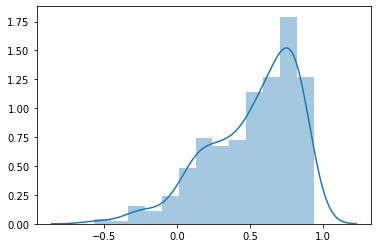

In [10]:
plot_correlation(luad,high_variability)

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 7)


['ATG16L2', -0.05540117929377982]


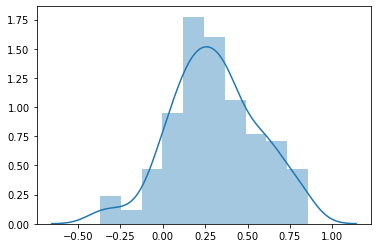

In [11]:
plot_correlation(luad, low_variability)

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 7)


['NID1', 0.4525936192414886]


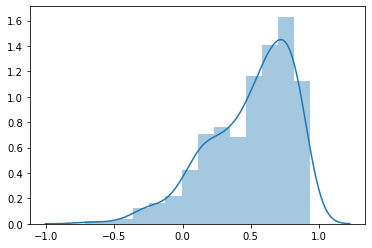

In [12]:
plot_correlation(luad, high_expression)

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 7)


['ATG16L2', -0.05540117929377982]


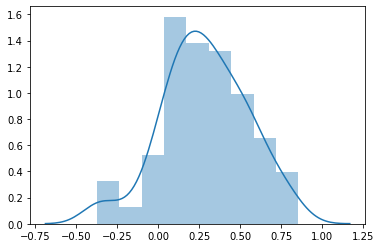

In [13]:
plot_correlation(luad, low_expression)

cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 11)


['THY1', 0.5882407366892874]


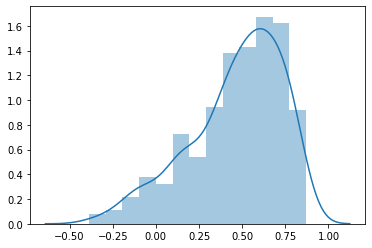

In [14]:
plot_correlation(gbm, high_variability)

cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 11)


['CLSPN', 0.5088754429262621]


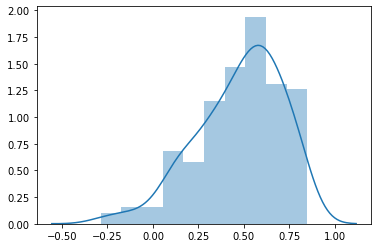

In [15]:
plot_correlation(gbm, low_variability)

['THY1', 0.5688356730296962]


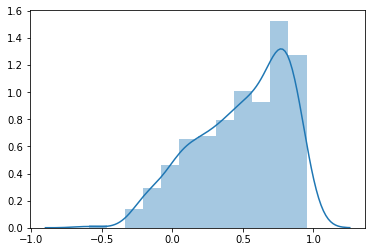

In [16]:
plot_correlation(end, high_variability)

['PLEKHB2', 0.7070011577264901]


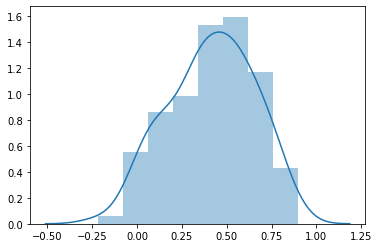

In [17]:
plot_correlation(end, low_variability)

In [18]:
print_single_gene_correlations("THY1",[luad,lscc,gbm,colon,end])

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 858 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 7)


[['THY1', 0.7251053564767009]]
[['THY1', 0.7908631947293928]]


cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 11)


[['THY1', 0.5882407366892874]]
[['THY1', 0.39549853375305194]]
[['THY1', 0.5688356730296962]]


In [19]:
print_single_gene_correlations('PLEKHB2',[luad,lscc,gbm,colon,end])

cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 858 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (/Users/benkk/anaconda3/envs/cptac_dev/lib/python3.7/site-packages/ipykernel_launcher.py, line 11)


[['PLEKHB2', 0.38980682240011555]]
[['PLEKHB2', 0.24283510337735556]]
[['PLEKHB2', 0.6593553409144497]]
[]
[['PLEKHB2', 0.7070011577264901]]
